In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import math
import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# ==================== 读取数据 ==================== #

df = pd.read_csv('FS_NYC.csv')                          #自动把第一行做列属性
df = df.loc[:,['userId','venueCategory']]               #取出用户ID和地点ID

# ==================== 获得地址字典 ==================== #

location = []                                           #取出所有的地址
for i in range(df.shape[0]):
    location.append(df.iloc[i,1])
location = list(set(location))                          #去重
loc_dict = dict(zip(location,range(len(location)))) #给这251个地点创建字典

# ==================== 分组获得每个人的运动轨迹 ==================== #

loc_rep = df.replace(loc_dict)                          #将地址名称替换成字典里的数字

def sliding_window(seq, window_size):
    result = []
    for i in range(len(seq)-window_size):
        result.append(seq[i:i+window_size])
    return result

train_set, test_set = [], []
window_size = 10   #窗口大小为10
for userId, group in loc_rep.groupby('userId'):
    full_seq = group['venueCategory']
    full_len = full_seq.shape[0]
    train_seq = full_seq.iloc[:int(full_len*0.7)].to_list()
    test_seq = full_seq.iloc[int(full_len*0.7):].to_list()
    train_set += sliding_window(train_seq, window_size)
    test_set += sliding_window(test_seq, window_size)

In [3]:
# ==================== RNN模型 ==================== #

class Rnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_size)
        #一定要加batch_first=True，因为我们的输入x是[batch,seq,input],但是默认的是[seq,batch,input]
        self.rnn = nn.RNN(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.out = nn.Linear(hidden_size,output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)                                           # x: torch.Size([128, 10])
        x = self.embedding(x)                                         # x: torch.Size([128, 10, 32])
        h = torch.zeros(1, batch_size, self.hidden_size).to(x.device) # h: #torch.Size([1, 128, 128])  
        y_list = []
        for i in range(seq_len):
            y, h = self.rnn(x, h)
            y_list.append(self.out(y[:, i, :]))
        return h, torch.stack(y_list, dim=1)

def next_batch(data, batch_size):
    data_length = len(data)
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

def train_evaluate(model, data_set, batch_size, optimizer):
    model.train()
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for batch in next_batch(shuffle(data_set), batch_size):
        batch = torch.from_numpy(np.array(batch)).long().to(device) #embedding层的输入需要long形式
        x = batch[:, :window_size-1].long().to(device)
        label =  batch[: , -1].long().to(device)
        hidden, out = model(x)                                 #输入直接是(batch_size, seq)，不用扩展最后一维
        prediction = out[:, -1, :].squeeze(-1)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_l_sum += loss.item()
        train_acc_sum += (prediction.argmax(dim=1) == label).sum().item() / label.shape[0]
        n += 1  #每个batch+1
    return train_l_sum/n, train_acc_sum/n

def test_evaluate(model, data_set, batch_size):
    model.eval()
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    with torch.no_grad():
        for batch in next_batch(shuffle(data_set), batch_size):
            batch = torch.from_numpy(np.array(batch)).long().to(device) #embedding层的输入需要long形式
            x = batch[:, :window_size-1].long().to(device)
            label =  batch[: , -1].long().to(device)
            hidden, out = model(x)                                 #输入直接是(batch_size, seq)，不用扩展最后一维
            prediction = out[:, -1, :].squeeze(-1)
            loss = loss_func(prediction, label)
            train_l_sum += loss.item()
            train_acc_sum += (prediction.argmax(dim=1) == label).sum().item() / label.shape[0]
            n += 1  #每个batch+1
    return train_l_sum/n, train_acc_sum/n

In [4]:
# ==================== lr=0.0001 ==================== #

device = 'cuda:1'
num_class = len(loc_dict)
model = Rnn(input_size=num_class, hidden_size=1024, output_size=num_class).to(device) #输出size是地址类别

loss_func = nn.CrossEntropyLoss()                                #多分类问题使用CrossEntropyLoss函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,70], gamma=0.1)

loss_train_1 = []
loss_test_1 = []
acc_train_1 = []
acc_test_1 = []
batch_size = 1024
num_epoch = 70
total_time_start_1 = datetime.datetime.now()
for epoch in range(num_epoch):
    start = datetime.datetime.now()
    train_l, train_acc = train_evaluate(model, train_set, batch_size, optimizer)
    test_l, test_acc = test_evaluate(model, test_set, batch_size)
    scheduler.step()
    loss_train_1.append(train_l)
    acc_train_1.append(train_acc)
    loss_test_1.append(test_l)
    acc_test_1.append(test_acc)
    end = datetime.datetime.now()
    print('epoch %d, loss_train %f, loss_test %f, acc_train %f, acc_test %f, time %s '% 
          (epoch+1, loss_train_1[epoch], loss_test_1[epoch], acc_train_1[epoch], acc_test_1[epoch], end - start))
total_time_end_1 = datetime.datetime.now()
print("lr=0.0001的运行时间：",total_time_end_1 - total_time_start_1)

epoch 1, loss_train 4.146542, loss_test 3.930449, acc_train 0.175943, acc_test 0.193666, time 0:00:21.788700 
epoch 2, loss_train 3.780901, loss_test 3.821893, acc_train 0.210582, acc_test 0.205770, time 0:00:21.966544 
epoch 3, loss_train 3.672227, loss_test 3.775190, acc_train 0.220761, acc_test 0.210713, time 0:00:22.275984 
epoch 4, loss_train 3.605115, loss_test 3.740082, acc_train 0.228017, acc_test 0.213031, time 0:00:22.363230 
epoch 5, loss_train 3.556653, loss_test 3.719786, acc_train 0.232838, acc_test 0.214919, time 0:00:22.525690 
epoch 6, loss_train 3.517409, loss_test 3.707989, acc_train 0.237223, acc_test 0.216833, time 0:00:22.972814 
epoch 7, loss_train 3.482231, loss_test 3.707049, acc_train 0.241184, acc_test 0.213965, time 0:00:22.761204 
epoch 8, loss_train 3.452785, loss_test 3.690515, acc_train 0.245045, acc_test 0.218821, time 0:00:23.445631 
epoch 9, loss_train 3.425085, loss_test 3.682688, acc_train 0.247280, acc_test 0.219855, time 0:00:22.968038 
epoch 10, 

In [ ]:
# ==================== lr = 0.0005 ==================== #

device = 'cuda:0'
num_class = len(loc_dict)
model = Rnn(input_size=num_class, hidden_size=128, output_size=num_class).to(device) #输出size是地址类别

loss_func = nn.CrossEntropyLoss()                                #多分类问题使用CrossEntropyLoss函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,70], gamma=0.1)

loss_train_2 = []
loss_test_2 = []
acc_train_2 = []
acc_test_2 = []
batch_size = 1024
num_epoch = 70
total_time_start_2 = datetime.datetime.now()
for epoch in range(num_epoch):
    start = datetime.datetime.now()
    train_l, train_acc = train_evaluate(model, train_set, batch_size, optimizer)
    test_l, test_acc = test_evaluate(model, test_set, batch_size)
    scheduler.step()
    loss_train_2.append(train_l)
    acc_train_2.append(train_acc)
    loss_test_2.append(test_l)
    acc_test_2.append(test_acc)
    end = datetime.datetime.now()
    print('epoch %d, loss_train %f, loss_test %f, acc_train %f, acc_test %f, time %s '% 
          (epoch+1, loss_train_2[epoch], loss_test_2[epoch], acc_train_2[epoch], acc_test_2[epoch], end - start))
total_time_end_2 = datetime.datetime.now()
print("lr=0.0005的运行时间：",total_time_end_2 - total_time_start_2)

In [6]:
fp_1=open('0.0001 1024.txt','r',encoding='utf-8')
loss_train_1 = []
loss_test_1 = []
acc_train_1 = []
acc_test_1 = []
for line in fp_1:
    line = line.strip(u'\\n')
    _, train_l, test_l, train_acc, test_acc, _ = line.split(u' ')
    loss_train_1.append(float(train_l))
    acc_train_1.append(float(train_acc))
    loss_test_1.append(float(test_l))
    acc_test_1.append(float(test_acc))

fp_2=open('0.0005 1024.txt','r',encoding='utf-8')
loss_train_2 = []
loss_test_2 = []
acc_train_2 = []
acc_test_2 = []
for line in fp_2:
    line = line.strip(u'\\n')
    _, train_l, test_l, train_acc, test_acc, _ = line.split(u' ')
    loss_train_2.append(float(train_l))
    acc_train_2.append(float(train_acc))
    loss_test_2.append(float(test_l))
    acc_test_2.append(float(test_acc))

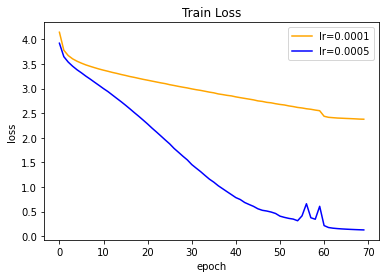

In [7]:
plt.plot(loss_train_1,label='lr=0.0001', color='orange')
plt.plot(loss_train_2,label='lr=0.0005',color='blue')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Train Loss")
plt.legend()
plt.show()

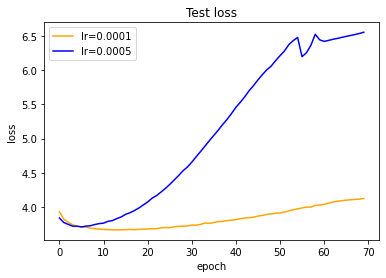

In [8]:
plt.plot(loss_test_1,label='lr=0.0001', color='orange')
plt.plot(loss_test_2,label='lr=0.0005',color='blue')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Test loss")
plt.legend()
plt.show()

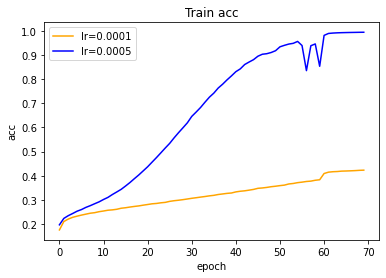

In [9]:
plt.plot(acc_train_1,label='lr=0.0001', color='orange')
plt.plot(acc_train_2,label='lr=0.0005',color='blue')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Train acc")
plt.legend()
plt.show()

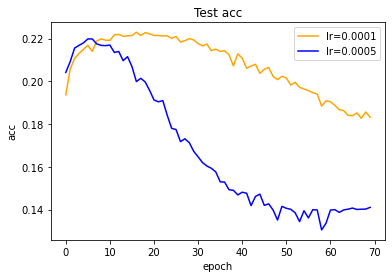

In [10]:
plt.plot(acc_test_1,label='lr=0.0001', color='orange')
plt.plot(acc_test_2,label='lr=0.0005',color='blue')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Test acc")
plt.legend()
plt.show()

In [11]:
data=[{"Time":"0:26:52.307403"},{"Time":"0:26:43.697119"}]
df = pd.DataFrame(data,columns=['Time'],index = ['lr=0.0001', 'lr=0.0005'])
df

,Time
lr=0.0001,0:26:52.307403
lr=0.0005,0:26:43.697119
